<a href="https://colab.research.google.com/github/beedrumms/eta_/blob/main/plane_crashes_cleaning_transformation_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting google colab on drive 
from google.colab import drive, files
import os
drive.mount("/content/drive")

import re 
import string
import pandas as pd 
import numpy as np
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import collections
from collections import Counter 
import itertools
from sklearn.feature_extraction.text import CountVectorizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/plane_crashes_data.csv', encoding= 'unicode_escape')

#Intention 
####the intention will be to ensure that 
a) all columns are atomic;
b) free of errors and large outliers, and;
c) transformed to allow for further analysis

####I will go variable by variable

In [3]:
#Starting out - the basic information from that dataset 
# and the as
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          5783 non-null   object
 1   time          5783 non-null   object
 2   location      5783 non-null   object
 3   operator      5783 non-null   object
 4   flight_no     5783 non-null   object
 5   route         5783 non-null   object
 6   ac_type       5783 non-null   object
 7   registration  5783 non-null   object
 8   cn_ln         5783 non-null   object
 9   aboard        5783 non-null   object
 10  fatalities    5783 non-null   object
 11  ground        5783 non-null   object
 12  summary       5783 non-null   object
dtypes: object(13)
memory usage: 587.5+ KB
None


,date,time,location,operator,flight_no,route,ac_type,registration,cn_ln,aboard,fatalities,ground,summary
count,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783
unique,5212,1339,4715,2821,877,3875,2742,5392,4070,1042,917,54,5368
top,"August 31, 1988",?,"Moscow, Russia",Aeroflot,?,?,Douglas DC-3,?,?,2 (passengers:0 crew:2),1 (passengers:0 crew:1),0,?
freq,4,2108,18,260,4436,1494,341,352,1207,236,288,5474,231


#Missing Info 

In [4]:
print("nans in set:", '\n', df.isna().sum()) # no nans -- however i know that there are many '?' which probably stands for 'unknown'

nans in set: 
 date            0
time            0
location        0
operator        0
flight_no       0
route           0
ac_type         0
registration    0
cn_ln           0
aboard          0
fatalities      0
ground          0
summary         0
dtype: int64


In [5]:
# Will be checking freqency of unknowns ('?') in each component - going to make a little function to reduce code 
def count_of_Qmark(s):
  missing_count = 0 
  for i in s:
    if '?' in i:
      missing_count += 1
    else:
      pass
  return missing_count

#Date - 
###Date of accident
####Initial qs: 
- All the same format? 
- Range? – looks like there are some flights in here that take place in the future..? 


In [6]:
#Split on year to see the date range we are working with
years = []
for i in df['date']:
  years.append(i[-4:])
print("length of series:", len(df['date']), "-----", "length of years list:", len(years))

df.insert (2, "years", years) #inserting into df

print("number of years in set =", df['years'].nunique())

fig = px.histogram(df, x="years", nbins=200)
fig.show()

length of series: 5783 ----- length of years list: 5783
number of years in set = 100


In [7]:
month = []
for i in df['date']:
  mon = re.sub('\d+[,]\s\d+','',i)
  mon2 = re.sub('\s','',mon) 
  month.append(mon2)
print("length of series:", len(df['date']), "-----", "length of years list:", len(month))

df.insert (2, "month", month) #inserting into df

print("number of months in set =", df['month'].nunique())

fig = px.histogram(df, x="month", nbins=12)
fig.show()

length of series: 5783 ----- length of years list: 5783
number of months in set = 12


In [8]:
# There appear to be around 100 entries that go into the future 
# going to take a look to see if entry error or something along those lines 
yr_filter = df['years'] >= '2022'
future = df[yr_filter]

# looking at the aircraft type, we can dicern that these dates are actually from the 1920s 
print("the aircraft types of the crashes for 2022-2029 dates:", '\n', future['ac_type'].unique())

the aircraft types of the crashes for 2022-2029 dates: 
 ['Handley Page O/10' 'Dirigible Roma (airship)'
 'Aeromarine Model 85 (flying boat)'
 'de Havilland DH-18 / Farman F-60 Goliath' '?' 'Bleriot Spad 27'
 'LVG C VI' 'Potez 29' 'Breguet 14' 'De Havilland DH-4'
 'de Havilland DH-9' 'LiorÃ©-et-Olivier H-13' 'Farman F-60 Goliath'
 'BlÃ©riot Spad 46' 'de Havilland DH-34' 'Junkers F-13'
 'Zeppelin Dixmunde (airship)' 'Fokker F.III' 'de Havilland DH-34B'
 'Fokker (KLM)  F.III' 'LiorÃ©-et-Olivier LeO H-13' 'Potez IX'
 'Dirigible ZR-1 Shenandoah (airship)' 'Spad 33' 'Curtiss Carrier Pigeon'
 'Caudron C-61' 'Fokker F7' 'Bleriot 155' 'Sikorsky S-25' 'Fokker FG III'
 'Handley Page W-10' 'Ryan M-1' 'Fokker F-VII' 'de Havilland DH-9C'
 'Swallow\nSwallow' 'Douglas M-4' 'SPCA Meteore 63' 'Fokker F-VIII'
 'Fokker Universal' 'Dornier Merkur' 'Fairchild FC-2'
 'Farman F-121 Jabiru' 'LatÃ©coÃ¨re 23 (flying boat)' 'Latecoere 25'
 'Boeing 40' 'Rohrbach Roland' 'Latecoere 26' 'Ford 4' 'AEGK'
 'Vickers 74

In [9]:
# replaing 2022-2029 with 1922-1929 
df['years']= df['years'].str.replace("2022", "1922")
df['years']= df['years'].str.replace("2023", "1923")
df['years']= df['years'].str.replace("2024", "1924")
df['years']= df['years'].str.replace("2025", "1925")
df['years']= df['years'].str.replace("2026", "1926")
df['years']= df['years'].str.replace("2027", "1927")
df['years']= df['years'].str.replace("2028", "1928")
df['years']= df['years'].str.replace("2029", "1929")

In [10]:
# The below ranges are within a reasonable time period
fig = px.histogram(df, x="years", nbins=200)
fig.show()

In [11]:
days = [] 
for i in df['date']:
  split = i.split(",")
  indx = split[0]
  y = re.sub('[,]$', '', indx)
  m = re.sub('[A-Za-z]*', '', y)
  s = re.sub('^\s*', '', m) 
  days.append(s)

df.insert(4, 'days', days)

# We can see that the days only fall within a reasonable range
fig = px.histogram(df, x="days", nbins=31)
fig.show()

In [12]:
month_year = df['month']+', '+df['years']
date = df['month']+' '+df['days']+', '+df['years']

# Replacing the date with the a concated date 
df['date'] = date
#adding a month - year column because i imgine that there may be a seasonal effect on the data
df.insert(1, 'month_year', month_year)

In [13]:
print("number of ? (indicating missing data):", count_of_Qmark(df['date'])) # zero missing / unknown data

number of ? (indicating missing data): 0


#Time 
####
-	time format – all the same unit? If not – reformat data to be all the same unit
- time has many missing entries 

In [14]:
ttimes = []
for i in df['time']:
  if '?' in i:
    ttimes.append(i)
  else:
    letters = re.sub('[A-Za-z]', '', i)
    colon = re.sub(':', '', letters)
    remove = re.sub('[;".]', '', colon)
    spaces = re.sub('^\s+|\s+$', '', remove)
    new_lines = re.sub('/\n|\r/g', '', spaces) # there is a few new lines in the set
    ttimes.append(new_lines)

for i in ttimes:
  j = len(i)
  if j == 5:
    print(i)

In [15]:
times = []
for i in ttimes:
  if '?' in i:
    times.append(i)
  else:
    j = len(i)
    if j >= 4:
      times.append(i.strip())
    elif j == 3:
      t = '0'+i[:]
      times.append(t.strip())
    elif j == 2:
      t = '00'+i[:]
      times.append(t.strip())
    else:
      t = '000'+i[:]
      times.append(t.strip())
times 

['1718',
 '?',
 '0630',
 '?',
 '1830',
 '1030',
 '0100',
 '1520',
 '?',
 '0100',
 '2345',
 '?',
 '2345',
 '?',
 '?',
 '0515',
 '0845',
 '?',
 '0700',
 '0745',
 '2130',
 '?',
 '1000',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '1215',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '1740',
 '?',
 '?',
 '?',
 '?',
 '1140',
 '1315',
 '?',
 '?',
 '?',
 '1645',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '1340',
 '?',
 '?',
 '1800',
 '?',
 '?',
 '0230',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '1200',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '0530',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '0930',
 '?',
 '?',
 '?',
 '?',
 '?',
 '1315',
 '0800',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '0830',
 '?',
 '?',
 '0405',
 '1000',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 

In [16]:
new_times_col = []
for i in times:
  j = len(i)
  if '?' in i:
    new_times_col.append(i)
  elif j == 4:
    new_times_col.append(i[:2]+":"+i[2:])  
  else: 
    new_times_col.append(i[:1]+":"+i[1:])  

# Checking the logic of my loop above -- if the # of question marks + the count of rows w/ characters == to 4 add up to the length of the df[time] series, it worked 
count = 0
counter = 0
for i in new_times_col:
  j = len(i)
  if '?' in i:
    pass
  elif j != 5:
    counter += 1
    print("pROBlem", i, counter)
  else:
    count +=1 
print("number of rows where time characters == 4:", count,'\n', "length of array:", len(times), '\n', "length of series in df:", len(df['time']),'\n', "if the program worked, # of '?' + the count of len(4) rows should equal the length of the df series:", count_of_Qmark(df['time']) +count)

df['time'] = new_times_col #overwriting the times column with edited times data

number of rows where time characters == 4: 3675 
 length of array: 5783 
 length of series in df: 5783 
 if the program worked, # of '?' + the count of len(4) rows should equal the length of the df series: 5783


In [17]:
print("number of ? (indicating missing data):", count_of_Qmark(df['time']))
# however there are 2108 missing flight times - indicated by '?' 

number of ? (indicating missing data): 2108


#Location
-	Make all under case for ease 
-	City, Country/Area – probably best to split these so they are atomic (city | country/area)
-	Some just say the country / state not the city (no delimitator) 
-	Input errors 
-	Some inputs say “1,200 miles off Dakar” 


In [18]:
#making lowercase for easier handling
temp_location = [] 
for i in df['location']:
  temp_location.append(i.lower())

df['location'] = temp_location

In [19]:
# I want to see how each observation refers to its location - most may be single places
# however a number of them are descriptive of their location at crashing

# going to make a function that creates top n-grams
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# going to feed the location column into my function
locations = df['location'].tolist()
common_words = get_top_n_trigram(locations, 15)

df_locations = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x= df_locations['trigram'], y= df_locations['count'])])
fig.update_layout(title=go.layout.Title(text="Top 15 Trigrams for Plane Crashes Location Data"))
fig.show()

In [20]:
proximity_flag = []
for i in df['location']:
  if 'near' in i:
    proximity_flag.append('1')
  elif 'off' in i:
    proximity_flag.append('1')
  elif 'miles' in i:
    proximity_flag.append('1')
  elif 'en route' in i:
    proximity_flag.append('1')
  elif 'ocean' in i:
    proximity_flag.append('1')
  else:
    proximity_flag.append('0')
len(proximity_flag)
df.insert(5, 'proximity_flag', proximity_flag)

In [21]:
# Going to remove all the stop words in the location data to try and isolation most of the geographic info 
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

all_stopwords = stopwords.words('english')

corp = [] 
for i in df['location']:
  token = word_tokenize(i)
  t_stpwords_removed = [word for word in token if not word in all_stopwords]
  text = (" ").join(t_stpwords_removed)
  corp.append(text)

corpus = []
for i in corp:
  nl = re.sub('/\n|\r/g', '', i)
  d = re.sub('[0-9]+(?=\smiles)', '', nl)
  m = re.sub('miles', '', d)
  o = re.sub('off', '', m)
  n = re.sub('near', '', o)
  r = re.sub('en route', '', n)
  corpus.append(r)

# appending processed list this to dataframe
df['location'] = corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# finally, im going to split on the last deliminator to get primary location 
p_location = [i.rsplit(",", 5) for i in df['location']] #split 5 becuase its the max length

primary_location = []
for i in p_location:
  index = len(i) - 1
  j = i[index]
  primary_location.append(j)
primary_location
df.insert(8, 'primary_location', primary_location)

In [23]:
secondary_location = []
for i in p_location:
  l = len(i)
  if l == 1:
    secondary_location.append('none')
  else:
    j = i[-2]
    secondary_location.append(j)
secondary_location
df.insert(9, 'secondary_location', secondary_location)

In [24]:
count_of_Qmark(df['location'])

6

#Operator 
-	Make all under case for ease 
-	Military – maybe create a dummy for this variable and then git rid 
-	Isolate the actual company / affiliation operating this plane 


In [25]:
# making lower case for 
l_operator = [i.lower() for i in df['operator']]
df['operator']=l_operator 

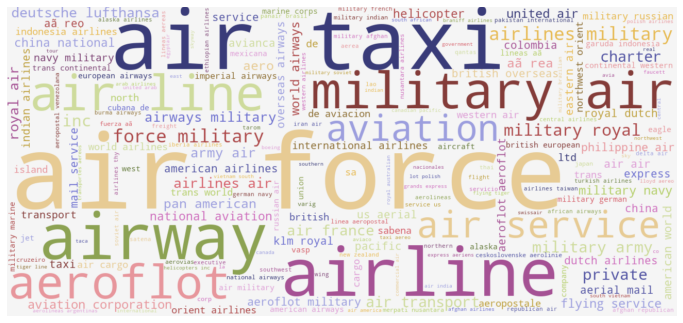

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
cloud_str = pd.Series(df['operator']).str.cat(sep=' ')
cloud = WordCloud(width=1300, height=600, max_font_size=200, background_color="whitesmoke", colormap="tab20b").generate(cloud_str) # creating the word cloud 
plt.figure(figsize=(12,12))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
# we know military is a common thing - so i will add a military flag
military_flg = []
for i in df['operator']:
  if 'military' in i:
    military_flg.append('1')
  else:
    military_flg.append('0')

df.insert(7, 'military_flg', military_flg) 

df['operator']= df['operator'].str.replace("military", "") # getting rid of military
df['operator']= df['operator'].str.replace("-", "") # getting rid of - 

In [28]:
# removing everything after a comma or ()
df['operator'] = df['operator'].str.replace('[,|(].*$', '') 

In [29]:
# now we are going to split column by deliminator '/' 
df[['operator_1', 'operator_2']] = df['operator'].str.split('/', expand=True)

#Flight_no 
-	Look at unique values? 
- Some data slippage 


In [30]:
df['flight_no'].nunique()
df['flight_no'].unique()

array(['?', 'F-AIKG', '7', '599', '6', '4', '1', '14', '34', '23', '15A',
       'LZ 129', '2', '8', '9', '229', '-', '19', '16', '21', '3', '203',
       '5', '71', '7208', '28', 'V-1104', '9035', '777', '63', '218',
       '13', '161', '6001', '142', '45', '216', '42', '105', '16B',
       '6-103', '513', '878', '850', '942', '404', '44', '115', '140',
       '48', '6963', '2207', '665', '521', '605', '410', '121', '311',
       '608', '1629', '923', '10', '572', '611', '700', '4422', '10-Jan',
       '624', '421', '331', '6427', '100', '897R', '557', '08-Nov', '537',
       '157', '500', '307', '2501', '903', '32', '245', '83', '493',
       '129', '151', '610', '615', 'CAM5763', '44-2', '501', '324',
       '6780', '101', '02-Apr', '526A', '416W', '202', '251', '201',
       '376', '841', '1-6-6A', '470', '162', '636', '783/057', '318',
       '18', '512', '723', '627', '783', '304/44', '270', '781', '314',
       '152', '971', '633', '136', '57', '792', '451', '4844-C', '329',
   

#Route
-	Lower case 
-	Some are multi-location, some are two location – come are just a training 
-	Multi-location, two-location, purpose (create categorical variable or dummy for each?) 
-	Split up routes? (like route1, route2, route3)


In [31]:
df['route'] = [i.lower() for i in df['route']] #make lower

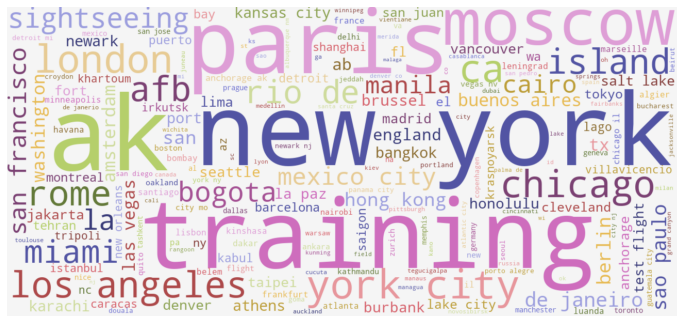

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
cloud2_str = pd.Series(df['route']).str.cat(sep=' ')
cloud2 = WordCloud(width=1300, height=600, max_font_size=200, background_color="whitesmoke", colormap="tab20b").generate(cloud2_str) # creating the word cloud 
plt.figure(figsize=(12,12))
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")

plt.show()

In [33]:
routes = [i.rsplit("-") for i in df['route']]
m = max([len(i) for i in routes]) # checking the max splits - multi destination flight

import statistics
a = statistics.mean([len(i) for i in routes]) # looking at the average (1.78)

count = 0
for i in routes:
  l = len(i)
  if l == 7:
    count += 1

# 3649 observations have 2 routes
# 284 have 3 routes 
# 75 have 4 routes
# 19 have 5 routes
# 4 have 6 
# 1 have 7 

In [34]:
# its a lot to have 7 differnt columns so we will start with 
# a) a training flight 
training_flg = ['1' if 'training' in i else '0' for i in df['route']]
df.insert(12, 'training_flg', training_flg)

# b) a multi_destination flag
multi_route_flg = ['1' if len(i)>1 else '0' for i in routes]
df.insert(13, 'multi_route_flg', multi_route_flg) 

# c) a count of how many destinations were planned
no_routes = [len(i) for i in routes]
df.insert(14, 'no_routes', no_routes)

# d) the route = the Complete or partial route flown prior to the accident 
routes = [i.split('-') for i in df['route']]
last = [i[-1] for i in routes]
last

last_l = [i.split(',') for i in last]

last_leg = []
for i in last_l:
  j = len(i)
  if j > 2:
    k = i[-2]+', '+i[-1]
    last_leg.append(k)
  else:
    last_leg.append(i)

ll = []
for i in last_leg:
  j = i[0]
  s = re.sub('^\s', '', j)
  ll.append(s)
  
df.insert(15, 'last_leg', ll)

#Ac_type
- Some entires have a split? ‘/’ 
-	Maybe get rid of model # to go in on manufacturer? i.e. ‘Doglas’ or ‘Boeing’ 
-	aircraft type designator – may have meaning as it could indicate airplane size


In [35]:
df['ac_type'] = [i.lower() for i in df['ac_type']] #lower case

In [36]:
# just going to remove the model number and keep the main producer
ac_t = [i.split() for i in df['ac_type']]
co = [i[0] for i in ac_t] # i dont know much about airplanes so the manufacurer + the year will tell me more than the model # 
comp = []
for i in co:
  num_ = re.sub('[0-9]*[-]*$', '', i)
  comp.append(num_)

df.insert(16, 'manufacturer', comp)

#Cn_in
- C/N (construction number) 
- S/N (serial number), MSN (manufacturers serial number)
- Boeings from time to time you see L/N (line number) 

#Registration
- changes per owner 
- shows country code

#Aboard
-	not atomic – contains the total and passenger / crew #s this should be split into three columns (total aboard – passengers aboard – crew aboard) – split by () and then by #space? 
-	Crew should never have 0? 


In [37]:
#going to split this into three parts 
totals = [i.rsplit() for i in df['aboard']]
total_aboard = [i[0] for i in totals]
# passengers 
pass_a = [i[1] for i in totals]
passengers_aboard = pd.Series(pass_a).str.replace('[(passengers:]', '')
# pilots
crew_a = [i[2] for i in totals]
crew_aboard = pd.Series(crew_a).str.replace('[(crew:)]', '')

# adding these items to the df -- also taking out aboard cause its not usefull 
del df['aboard']

total_aboard_ed = pd.to_numeric(total_aboard, errors='coerce')
passengers_aboard_ed = pd.to_numeric(passengers_aboard, errors='coerce')
crew_aboard_ed = pd.to_numeric(crew_aboard, errors='coerce')

df.insert(17,'total_aboard',total_aboard_ed)
df.insert(18,'passengers_aboard', passengers_aboard_ed)
df.insert(19, 'crew_aboard', crew_aboard_ed)

In [38]:
fig = px.histogram(df, x="total_aboard", nbins=100)
fig.show() # largest commercial passenger jet is the Airbus 380 (A380) can carry a maximum of 853 passengers - so this range checks out 

#Fatalities

In [39]:
#going to split this into three parts 
ftotals = [i.rsplit() for i in df['fatalities']]
total_passed = [i[0] for i in ftotals]
# passengers 
pass_f = [i[1] for i in ftotals]
passengers_passed = pd.Series(pass_f).str.replace('[(passengers:]', '')
# pilots
crew_f = [i[2] for i in ftotals]
crew_passed = pd.Series(crew_f).str.replace('[(crew:)]', '')

# adding these items to the df -- also taking out aboard cause its not usefull 
del df['fatalities']

total_passed_ed = pd.to_numeric(total_passed, errors='coerce')
passengers_passed_ed = pd.to_numeric(passengers_passed, errors='coerce')
crew_passed_ed = pd.to_numeric(crew_passed, errors='coerce')

df.insert(20,'total_passed', total_passed_ed)
df.insert(21,'passengers_passed', passengers_passed_ed)
df.insert(22, 'crew_passed', crew_passed_ed)

In [40]:
fig = px.histogram(df, x="total_passed", nbins=100)
fig.show() # pretty significant outlier below 

#Ground

In [41]:
df['ground'] = df['ground'].str.replace('?','')
ground = pd.to_numeric(df['ground'], errors='coerce')
ground.describe() # this looks pretty skewed 
# so i will look at the max values here 
p_e = ground > 100
possible_error = df[p_e]
for i in possible_error['summary']:
  print(i)

df['ground'] = ground

# the large outlier in the ground set is actully 9/11 

The cargo plane undershot runway by 1 mile while making a radar approach in fog at night. Crashed into numerous thatched roof houses.
The aircraft failed to climb and crashed into trees, poles and houses at the end of the runway and came to rest in a soccer field 560 meters beyond the runway. The failure of the crew to select enough thrust to achieve the necessary acceleration. Crew fatigue.
The aircraft failed to gain altitude after taking off from N'Dolo Airport and ran off the runway and crashed into a market square. The plane was overloaded by 595 lbs. The aircraft certification was revoked and crew did not have authorization to fly. The number killed on the ground varies widely from different sources. The number of fatalities, 225, is derived from the publication Weekly Mail and Guardian in an article covering the court trial of the pilots, charging them with the deaths of 225 people. Some sources quote as many as 350 died.
The aircraft was hijacked shortly after it left Logan Int

#Summary

In [42]:
# for summary - im just going to get rid of stopwords
comments = [] 
for i in df['summary']:
  token = word_tokenize(i)
  t_stpwords_removed = [word for word in token if not word in all_stopwords]
  text = (" ").join(t_stpwords_removed)
  comments.append(text)
df['summary_ed'] = comments

#Validation
- total aboard == total passengers + total crew
- total passed == total passengers passed + total crew passed
- fatalities should not excede those on the flight (unless on the ground) 
- reorg columns to using differnt imputations methods 
- replace ? with nans 
- ideally imputation (if time) 

In [43]:
# Aboard
pass_plus_crew = df['passengers_aboard'] + df['crew_aboard']
test1 = df['total_aboard'] - pass_plus_crew 
test_1_true = []
for i in test1:
  if i > 0:
    test_1_true.append(True)
  elif i < 0: # want to skip over nans 
    test_1_true.append(True)
  else:
    test_1_true.append(False)

df['test1_aboard'] = test_1_true

df = df.loc[df['test1_aboard'] != True] # we can not be certain of which number is missrecorded (total, passengers or crew) - and its really small amount of data so i am going to remove it 

In [44]:
# Fatalities 
pass_pls_crew = df['passengers_passed'] + df['crew_passed']
test2 = df['total_passed'] - pass_pls_crew 
test_2_true = []
for i in test2:
  if i > 0:
    test_2_true.append(True)
  elif i < 0: # want to skip over nans 
    test_2_true.append(True)
  else:
    test_2_true.append(False)

df['test2_fatalities'] = test_2_true

df = df.loc[df['test2_fatalities'] != True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
# Total aboard and fatalities
aboard_fatalities = df['total_aboard'] - df['total_passed']
for i in aboard_fatalities:
  if i < 0: 
    print(i)
# ok this checks out - no # of fatalities pass the # aboard

In [46]:
#this should take care of all outliers 

In [47]:
df_f = pd.DataFrame(zip(df['date'], df['month_year'], df['time'], df['month'], df['days'], df['years'], df['location'], df['proximity_flag'], 
                      df['operator_1'], df['operator_2'], df['military_flg'], df['primary_location'], df['secondary_location'], df['route'], df['last_leg'],
                      df['training_flg'], df['multi_route_flg'], df['no_routes'], df['ac_type'], df['manufacturer'], df['registration'], df['summary'], 
                      df['summary_ed'], df['flight_no'], df['total_aboard'], df['passengers_aboard'], df['crew_aboard'], 
                      df['total_passed'], df['passengers_passed'], df['crew_passed'], df['ground']))

df_f.columns = ['date', 'month_year', 'time', 'month', 'days', 'years', 'location','proximity_flag', 
                      'operator_1','operator_2','military_flg','primary_location','secondary_location','route', 'last_leg',
                      'training_flg','multi_route_flg','no_routes','ac_type','manufacturer','registration','summary', 
                      'summary_ed','flight_no','total_aboard','passengers_aboard','crew_aboard', 
                      'total_passed','passengers_passed','crew_passed','ground_passed']

In [48]:
print(count_of_Qmark(df_f['time']))
print(count_of_Qmark(df_f['location']))
print(count_of_Qmark(df_f['route']))
print(count_of_Qmark(df_f['summary']))

2090
6
1494
230


In [49]:
df_f.applymap(lambda x: np.nan if x == '?' else x) # getting rid of ?

,date,month_year,time,month,days,years,location,proximity_flag,operator_1,operator_2,military_flg,primary_location,secondary_location,route,last_leg,training_flg,multi_route_flg,no_routes,ac_type,manufacturer,registration,summary,summary_ed,flight_no,total_aboard,passengers_aboard,crew_aboard,total_passed,passengers_passed,crew_passed,ground_passed
0,"September 17, 2008","September, 2008",17:18,September,17,2008,"fort myer , virginia",0,u.s. army,None,1,virginia,fort myer,demonstration,demonstration,0,0,1,wright flyer iii,wright,NaN,"During a demonstration flight, a U.S. Army fly...","During demonstration flight , U.S. Army flyer ...",NaN,2.0,1.0,1.0,1.0,1.0,0.0,0.0
1,"July 12, 2012","July, 2012",06:30,July,12,2012,"atlantic city , new jersey",0,u.s. navy,None,1,new jersey,atlantic city,test flight,test flight,0,0,1,dirigible,dirigible,NaN,First U.S. dirigible Akron exploded just offsh...,First U.S. dirigible Akron exploded offshore a...,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0
2,"August 6, 2013","August, 2013",NaN,August,6,2013,"victoria , british columbia , canada",0,private,None,0,canada,british columbia,NaN,NaN,0,0,1,curtiss seaplane,curtiss,NaN,The first fatal airplane accident in Canada oc...,The first fatal airplane accident Canada occur...,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,"September 9, 2013","September, 2013",18:30,September,9,2013,north sea,0,german navy,None,1,north sea,none,NaN,NaN,0,0,1,zeppelin l-1 (airship),zeppelin,NaN,The airship flew into a thunderstorm and encou...,The airship flew thunderstorm encountered seve...,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0
4,"October 17, 2013","October, 2013",10:30,October,17,2013,"johannisthal , germany",1,german navy,None,1,germany,johannisthal,NaN,NaN,0,0,1,zeppelin l-2 (airship),zeppelin,NaN,Hydrogen gas which was being vented was sucked...,Hydrogen gas vented sucked forward engine igni...,NaN,30.0,NaN,NaN,30.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,"July 10, 2018","July, 2018",07:44,July,10,2018,"pretoria , south africa",0,rovos air,None,0,south africa,pretoria,test flight,test flight,0,0,1,convair cv-340,convair,ZS-BRV,"Shortly after takeoff from runway 29, the left...","Shortly takeoff runway 29 , left engine failed...",NaN,19.0,16.0,3.0,1.0,0.0,1.0,1.0
5738,"August 4, 2018","August, 2018",16:55,August,4,2018,"flims , switzerland",0,ju air,None,0,switzerland,flims,locorno - dubendorf,dubendorf,0,1,2,junkers ju-52,junkers,HB-HOT,The vintage aircraft crashed onto Piz Segnas m...,The vintage aircraft crashed onto Piz Segnas m...,NaN,20.0,17.0,3.0,20.0,17.0,3.0,1.0
5739,"September 28, 2018","September, 2018",10:10,September,28,2018,"chuuk , micronesia",0,air niugini,None,0,micronesia,chuuk,pohnpei - chuuk,chuuk,0,1,2,boeing 737-8bk,boeing,P2-PXE,The aircraft was approaching for a landing at ...,The aircraft approaching landing Chuuk/Weno Ai...,NaN,47.0,35.0,12.0,1.0,1.0,0.0,0.0
5740,"October 29, 2018","October, 2018",06:31,October,29,2018,"jakarta , indonesia",1,lion air,None,0,indonesia,jakarta,jakarta - pangkal pinang,pangkal pinang,0,1,2,boeing 737-max 8,boeing,PK-LQP,"The airliner crashed into the Jakarta Sea, 13 ...","The airliner crashed Jakarta Sea , 13 minutes ...",610,189.0,181.0,8.0,189.0,181.0,8.0,0.0


In [50]:
#Outliers 
print("Highest allowed - aboard",df_f['total_aboard'].mean() + 3*df_f['total_aboard'].std())
print("Lowest allowed - aboard",df_f['total_aboard'].mean() - 3*df_f['total_aboard'].std())

print("Highest allowed - fatalities",df_f['total_passed'].mean() + 3*df_f['total_passed'].std())
print("Lowest allowed - fatalities",df_f['total_passed'].mean() - 3*df_f['total_passed'].std())

print("Highest allowed - ground",df_f['ground_passed'].mean() + 3*df_f['ground_passed'].std())
print("Lowest allowed - ground",df_f['ground_passed'].mean() - 3*df_f['ground_passed'].std())

Highest allowed - aboard 155.59194622853198
Lowest allowed - aboard -100.64105180552252
Highest allowed - fatalities 118.94233166484344
Lowest allowed - fatalities -79.0473744147998
Highest allowed - ground 157.07004550583352
Lowest allowed - ground -154.01258635981347


In [53]:
limit_aboard = df_f['total_passed'] < 155.6
df_t = df_f[limit_aboard]
limit_fatalities = df_t['total_passed'] < 119
df_tt = df_t[limit_fatalities]
limit_ground = df_tt['ground_passed'] < 157
df_fin = df_tt[limit_ground]
df_fin.head(4)

,date,month_year,time,month,days,years,location,proximity_flag,operator_1,operator_2,military_flg,primary_location,secondary_location,route,last_leg,training_flg,multi_route_flg,no_routes,ac_type,manufacturer,registration,summary,summary_ed,flight_no,total_aboard,passengers_aboard,crew_aboard,total_passed,passengers_passed,crew_passed,ground_passed
0,"September 17, 2008","September, 2008",17:18,September,17,2008,"fort myer , virginia",0,u.s. army,None,1,virginia,fort myer,demonstration,demonstration,0,0,1,wright flyer iii,wright,?,"During a demonstration flight, a U.S. Army fly...","During demonstration flight , U.S. Army flyer ...",?,2.0,1.0,1.0,1.0,1.0,0.0,0.0
1,"July 12, 2012","July, 2012",06:30,July,12,2012,"atlantic city , new jersey",0,u.s. navy,None,1,new jersey,atlantic city,test flight,test flight,0,0,1,dirigible,dirigible,?,First U.S. dirigible Akron exploded just offsh...,First U.S. dirigible Akron exploded offshore a...,?,5.0,0.0,5.0,5.0,0.0,5.0,0.0
2,"August 6, 2013","August, 2013",?,August,6,2013,"victoria , british columbia , canada",0,private,None,0,canada,british columbia,?,?,0,0,1,curtiss seaplane,curtiss,?,The first fatal airplane accident in Canada oc...,The first fatal airplane accident Canada occur...,?,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,"September 9, 2013","September, 2013",18:30,September,9,2013,north sea,0,german navy,None,1,north sea,none,?,?,0,0,1,zeppelin l-1 (airship),zeppelin,?,The airship flew into a thunderstorm and encou...,The airship flew thunderstorm encountered seve...,?,20.0,NaN,NaN,14.0,NaN,NaN,0.0


#Export Final Version

In [54]:
#Export Clean dataframe
df_fin.to_csv('/content/drive/MyDrive/Colab Notebooks/plane_crashes_data_processed.csv')